# HuggingFace 커스텀 프로젝트
- model(klue/ber-base)를 활용하여 NSMC(Naver Sentiment Movie Corpus) task 수행
- 데이터: https://github.com/e9t/nsmc
- model: https://huggingface.co/klue/bert-base

In [15]:
import tensorflow
import numpy as np
import transformers
import datasets

print(tensorflow.__version__)
print(np.__version__)
print(transformers.__version__)
print(datasets.__version__)

2.6.0
1.21.4
4.11.3
1.14.0


## Dataset

### Huggingface dataset에서 불러오기
NSMC 데이터셋 https://huggingface.co/datasets/Blpeng/nsmc

In [16]:
from datasets import load_dataset

ds = load_dataset("Blpeng/nsmc")
ds

Using custom data configuration Blpeng___nsmc-55757a98c8abea78
Reusing dataset csv (/aiffel/.cache/huggingface/datasets/csv/Blpeng___nsmc-55757a98c8abea78/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'id', 'document', 'label'],
        num_rows: 400000
    })
})

train 데이터만 존재 -> 데이터 분할 필요

In [17]:
train = ds['train']
cols = train.column_names
for i in range(5):
    for col in cols:
        print(col, ":", train[col][i])
    print('\n')

Unnamed: 0 : 0
id : 8112052
document : 어릴때보고 지금다시봐도 재밌어요ㅋㅋ
label : 1


Unnamed: 0 : 1
id : 8132799
document : 디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업이 부러웠는데. 사실 우리나라에서도 그 어려운시절에 끝까지 열정을 지킨 노라노 같은 전통이있어 저와 같은 사람들이 꿈을 꾸고 이뤄나갈 수 있다는 것에 감사합니다.
label : 1


Unnamed: 0 : 2
id : 4655635
document : 폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.
label : 1


Unnamed: 0 : 3
id : 9251303
document : 와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런게 진짜 영화지
label : 1


Unnamed: 0 : 4
id : 10067386
document : 안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.
label : 1




### 불필요한 열 제거

In [18]:
ds = ds['train']
ds = ds.remove_columns(['Unnamed: 0', 'id'])
ds

Dataset({
    features: ['document', 'label'],
    num_rows: 400000
})

### 데이터셋 줄이기
원본 데이터로 학습하면 epoch 1에 약 8시간

In [19]:
small_ds = ds.shuffle(seed=42).select(range(int(0.1 * len(ds))))

Loading cached shuffled indices for dataset at /aiffel/.cache/huggingface/datasets/csv/Blpeng___nsmc-55757a98c8abea78/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a/cache-4b7488257526ee44.arrow


### 결측치 제거

In [20]:
# 결측치를 제거하는 함수 정의
def remove_missing_values(data):
    # 모든 값이 존재하는지 확인
    return all(value is not None for value in data.values())

# train, test 데이터셋에서 결측치 제거
dataset = small_ds.filter(remove_missing_values)
dataset

Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/csv/Blpeng___nsmc-55757a98c8abea78/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a/cache-c3384dd26d1364fe.arrow


Dataset({
    features: ['document', 'label'],
    num_rows: 39996
})

약 16개의 데이터 제거됨

> Q. tokeinzer에 전처리 과정도 포함되어 있는 거 아닌가? 왜 결측치가 있는 데이터는 못 받지?  
A. 텍스트 데이터를 모델이 이해할 수 있는 형식으로 변환하는 작업은 가능하지만, 결측치 제거와 같은 데이터 전처리 과정은 포함되어 있지 않음

## Tokenizer & Model
klue/ber-base 모델 https://huggingface.co/klue/bert-base  
> **모델 선정 이유**: 한국어 데이터셋에 대해 학습된 bert기반 모델이므로 한국어 데이터셋인 nsmc task에 적합하다

Auto Classes 활용

In [21]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")
model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base")

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

### 토큰화

In [22]:
def transform(data):
    return tokenizer(
        data['document'],
        truncation = True,
        padding = 'max_length',
        return_token_type_ids = False,    # binary classificaiton task에는 필요 없음
        )

tokenized_dataset = dataset.map(transform, batched=True)
tokenized_dataset

Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/csv/Blpeng___nsmc-55757a98c8abea78/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a/cache-853cf1e1ad9f6aa7.arrow


Dataset({
    features: ['attention_mask', 'document', 'input_ids', 'label'],
    num_rows: 39996
})

In [23]:
# 필요없는 열 삭제
tokenized_dataset = tokenized_dataset.remove_columns(['document'])
tokenized_dataset

Dataset({
    features: ['attention_mask', 'input_ids', 'label'],
    num_rows: 39996
})

### 데이터 분할

In [24]:
train_validtest = tokenized_dataset.train_test_split(test_size=0.2)
valid_test = train_validtest['test'].train_test_split(test_size=0.5)

train_data = train_validtest["train"]
valid_data = valid_test["train"]
test_data = valid_test["test"]

In [25]:
train_data

Dataset({
    features: ['attention_mask', 'input_ids', 'label'],
    num_rows: 31996
})

## Trainer

### 학습 준비

In [12]:
!pip install tensorboard

In [13]:
# 학습 관련 설정을 미리 지정
from transformers import Trainer, TrainingArguments

output_dir = './outputs'

training_arguments = TrainingArguments(
    run_name="lr=5e-5",
    fp16=True,
    output_dir=output_dir,                   # output_dir을 변수로 지정
    evaluation_strategy="steps",             # evaluation 하는 빈도
    eval_steps=1000,                         # 1000 스텝마다 평가 수행
    logging_dir='./logs',
    learning_rate=5e-5,                      # learning rate
    per_device_train_batch_size=8,           # 각 device 당 batch size
    per_device_eval_batch_size=8,            # evaluation 시에 batch size
    num_train_epochs=1,                      # train 시킬 총 epochs
    weight_decay=0.01,                       # weight decay
    report_to="tensorboard"                  # TensorBoard에 로그를 기록
)

In [26]:
from datasets import load_metric
metric = load_metric("accuracy")

# binary classification
def compute_metrics(eval_pred):    
    predictions,labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references = labels)

> **metric 선정 이유**: 긍/부정을 판단하는 이진 분류 문제이므로 accuracy가 평가 지표로서 적합하다

### 학습

In [15]:
# 캐시 지우기
import torch, gc

gc.collect()
torch.cuda.empty_cache()

하지 않으면 cuda out of memory 문제가 발생함

In [16]:
trainer = Trainer(
    model=model,           # 학습시킬 model
    args=training_arguments,   # TrainingArguments을 통해 설정한 arguments
    train_dataset=train_data,    # training dataset
    eval_dataset=valid_data,       # evaluation dataset
    compute_metrics=compute_metrics,
)
train_result = trainer.train()

Using amp fp16 backend
***** Running training *****
  Num examples = 31996
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4000


Step,Training Loss,Validation Loss,Accuracy
1000,0.382300,0.398694,0.832250
2000,0.369200,0.318621,0.878750
3000,0.343300,0.337895,0.882500
4000,0.315100,0.301302,0.891250


/opt/conda/lib/python3.9/site-packages/transformers/trainer.py:1355: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  nn.utils.clip_grad_norm_(
Saving model checkpoint to ./outputs/checkpoint-500
Configuration saved in ./outputs/checkpoint-500/config.json
Model weights saved in ./outputs/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 8
Saving model checkpoint to ./outputs/checkpoint-1000
Configuration saved in ./outputs/checkpoint-1000/config.json
Model weights saved in ./outputs/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./outputs/checkpoint-1500
Configuration saved in ./outputs/checkpoint-1500/config.json
Model weights saved in ./outputs/checkpoint-1500/py

#### 학습률 5e-5로 변경
Validation accuracy: 0.891250  
('train_runtime': 2136)
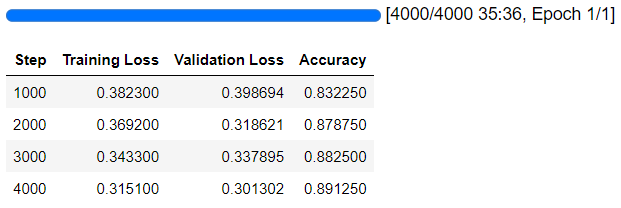

In [17]:
# 평가
trainer.evaluate(test_data)

***** Running Evaluation *****
  Num examples = 4000
  Batch size = 8


{'eval_loss': 0.31019893288612366,
 'eval_accuracy': 0.883,
 'eval_runtime': 139.0713,
 'eval_samples_per_second': 28.762,
 'eval_steps_per_second': 3.595,
 'epoch': 1.0}

# 실험
### data collator와 group_by_length 옵션 추가

- group_by_length: Trainer는 비슷한 길이의 샘플들을 같은 배치로 묶음
- DataCollatorWithPadding: 각 배치 내에서 가장 긴 샘플의 길이에 맞춰 나머지 샘플에 패딩을 추가

In [27]:
# 캐시 지우기
import torch, gc

gc.collect()
torch.cuda.empty_cache()

In [31]:
from transformers import DataCollatorWithPadding
from transformers import Trainer, TrainingArguments


tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")
model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

output_dir = './outputs'

training_arguments = TrainingArguments(
    fp16=True,
    output_dir=output_dir,                   # output_dir을 변수로 지정
    evaluation_strategy="steps",             # evaluation 하는 빈도
    eval_steps=1000,                         # 1000 스텝마다 평가 수행
    learning_rate=5e-5,                      # learning rate
    per_device_train_batch_size=8,           # 각 device 당 batch size
    per_device_eval_batch_size=8,            # evaluation 시에 batch size
    num_train_epochs=1,                      # train 시킬 총 epochs
    weight_decay=0.01,                       # weight decay
    group_by_length=True                     # 길이에 따라 배치를 그룹화
)

trainer = Trainer(
    model=model,           # 학습시킬 model
    args=training_arguments,   # TrainingArguments을 통해 설정한 arguments
    train_dataset=train_data,    # training dataset
    eval_dataset=valid_data,       # evaluation dataset
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

loading configuration file https://huggingface.co/klue/bert-base/resolve/main/config.json from cache at /aiffel/.cache/huggingface/transformers/fbd0b2ef898c4653902683fea8cc0dd99bf43f0e082645b913cda3b92429d1bb.99b3298ed554f2ad731c27cdb11a6215f39b90bc845ff5ce709bb4e74ba45621
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}

loading file https://huggingface.co/klue/bert-base/resolve/main/vocab.txt from cache at /aiffel/.cache/huggingface/transformers/1a36e69d48a0

In [32]:
train_result = trainer.train()

***** Running training *****
  Num examples = 31996
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4000
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Currently logged in as: 4rldur0 (4-rldur0). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy
1000,0.400700,0.333274,0.861750
2000,0.353200,0.325563,0.872500
3000,0.351400,0.320372,0.882750
4000,0.333800,0.312796,0.888500


/opt/conda/lib/python3.9/site-packages/transformers/trainer.py:1355: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  nn.utils.clip_grad_norm_(
Saving model checkpoint to ./outputs/checkpoint-500
Configuration saved in ./outputs/checkpoint-500/config.json
Model weights saved in ./outputs/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./outputs/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./outputs/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 8
Saving model checkpoint to ./outputs/checkpoint-1000
Configuration saved in ./outputs/checkpoint-1000/config.json
Model weights saved in ./outputs/checkpoint-1000/pytorch_model.bin
tokenizer

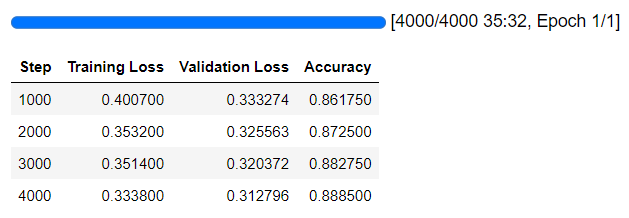